# Emotional Sentiment on Twitter
## A coronavirus vaccine online firestorm

<img src="images/Average_sentiment_during_onlinestorm.png">

The ongoing competition for a viable vaccine against coronavirus is arguably the race of the century. With its hundred millions of users, Twitter is particularly well-suited for research into sentiment and emotions running in social media. 

I collected the data scraping tweets from Twitter’s application program inter-face (API), using TwitterScraper. Tweets were scraped using the search term "Curevac", the name of a German vaccine maker backed by Bill & Melinda Gates Foundation, and currently working on a Covid-19 vaccine. The post covers tweets from a 6-year period, from March 3, 2014 to March 18, 2020 (N = 14,991).

In this notebook you will find examples of some of the most common NLP (Natural Language Processing) techniques used to uncover patterns of sentiment and emotion on social media microbloguing platforms like Twitter. It is organized as follows:

- Step 1: Exploratory analysis
- Step 2: Text processing
- Step 3: Sentiment analysis 
- Step 4: Word frequency 
- Step 5: LDA topics extraction
- Step 6: Emotion analysis


## Step 1:  EXPLORATORY ANALYSIS

After scrapping the Twitter API, the retained tweets were gathered on a csv file: tweets.csv.

Let's strat by importing the Python packages used for data handling (pandas), scientific computing (numpy) and data visualization (matplotlib and seaborn).

In [1]:
import pandas as pd 
import numpy as np
import jsonlines

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from collections import defaultdict
from datetime import date

import re # for regular expressions
import string

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Importing the data

In [4]:
#Importing Dataset
olafScholzJsonLines = jsonlines.open("OlafScholz.jl")

olafScholzTwitter = pd.read_json("OlafScholz.jl", lines = True)
print("Datensatzlänge: " + str(olafScholzTwitter.info()))

print(olafScholzTwitter.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   http_status   65 non-null     int64 
 1   account_name  65 non-null     object
 2   account_data  65 non-null     object
 3   params        65 non-null     object
 4   response      65 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.7+ KB
Datensatzlänge: None
   http_status account_name  \
0          200   OlafScholz   
1          200   OlafScholz   
2          200   OlafScholz   
3          200   OlafScholz   
4          200   OlafScholz   

                                        account_data  \
0  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
1  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
2  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
3  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
4  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   

         

In [5]:
# Reply Dataframe
# Importing Data into final Dataframe for ML
df = pd.DataFrame(columns = ["datetime", "text"])
iterator = 0

for line in olafScholzJsonLines:
    keyResponse = line["response"]
    data = keyResponse["data"]
    newDataRow = [None, None]
    userName = line["account_name"]
    keyResponse = line["response"]
    data = keyResponse["data"]


    for tweet in data:

        tweetTarget = 1
       
        tweetDate = tweet["created_at"][0:10]+" "+tweet["created_at"][11:19]
        tweetText = tweet["text"]  
        
        newDataRow[0] = tweetDate
        newDataRow[1] = tweetText
        df.loc[len(df)] = newDataRow
    iterator += 1

print(df.head())

              datetime                                               text
0  2022-04-17 07:11:52  RT @Bundeskanzler: Ich wünsche Ihnen und Ihren...
1  2022-04-14 16:40:32  RT @Bundeskanzler: Meine Solidarität gilt @Kar...
2  2022-04-13 17:16:53  RT @Bundeskanzler: Sie haben Hilfe organisiert...
3  2022-04-13 14:58:53  RT @Bundeskanzler: Verantwortung übernehmen he...
4  2022-04-12 18:59:51  RT @Bundeskanzler: Die Sanktionen gegen #Russl...


In [6]:
#cleansedTweetDF = replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:") or replyDataFrame["text"].str.contains("!RT @") ]
print("Size of dataframe :\n"+ str(df.count())+"\n----")
maskBundesKanz = df["text"].str.contains("RT @Bundeskanzler:")
maskNoRT = df["text"].str.contains("RT @")==False
print("Size of dataframe with RT @Bundeskanzler:\n" + str(df[maskBundesKanz].count())+"\n----")
print("Size of dataframe without RT @:\n" + str(df[maskNoRT].count())+"\n----")
#cleansedTweetDF contains all Tweets posted directly by Olaf before or after being Kanzler
cleansedTweetDF = df[maskBundesKanz | maskNoRT]
print("Size of cleansedTweetDF @:\n" + str(cleansedTweetDF.count())+"\n----")
print(df.head())
#cleansedTweetDF has "RT @Bundeskanzler:" still in the tweet. To not have any issues with ML we removed that part of the Tweet in the following parts

Size of dataframe :
datetime    6419
text        6419
dtype: int64
----
Size of dataframe with RT @Bundeskanzler:
datetime    48
text        48
dtype: int64
----
Size of dataframe without RT @:
datetime    4071
text        4071
dtype: int64
----
Size of cleansedTweetDF @:
datetime    4119
text        4119
dtype: int64
----
              datetime                                               text
0  2022-04-17 07:11:52  RT @Bundeskanzler: Ich wünsche Ihnen und Ihren...
1  2022-04-14 16:40:32  RT @Bundeskanzler: Meine Solidarität gilt @Kar...
2  2022-04-13 17:16:53  RT @Bundeskanzler: Sie haben Hilfe organisiert...
3  2022-04-13 14:58:53  RT @Bundeskanzler: Verantwortung übernehmen he...
4  2022-04-12 18:59:51  RT @Bundeskanzler: Die Sanktionen gegen #Russl...


In [7]:
# Removing the Text \"RT @Bundeskanzler:\" from the text\n
print("ReplyDataframe: \n" + str(df[maskBundesKanz].count()))
tweets = df[maskBundesKanz].copy()
tweets.text = df.text.str.strip("RT @Bundeskanzler: ")
print(tweets.head())  

ReplyDataframe: 
datetime    48
text        48
dtype: int64
              datetime                                               text
0  2022-04-17 07:11:52  Ich wünsche Ihnen und Ihren Familien frohe #Os...
1  2022-04-14 16:40:32  Meine Solidarität gilt @Karl_Lauterbach: Jeder...
2  2022-04-13 17:16:53  Sie haben Hilfe organisiert, Kräfte gebündelt ...
3  2022-04-13 14:58:53  Verantwortung übernehmen heißt: Deutschland li...
4  2022-04-12 18:59:51  Die Sanktionen gegen #Russland sind notwendig ...


In [8]:
# getting the date column ready for datetime operations
tweets['datetime']= pd.to_datetime(tweets['datetime'])

Here is a view of the first rows:

In [9]:
tweets.head()
tweets.dtypes

datetime    datetime64[ns]
text                object
dtype: object

And here is a plot of the tweets with the word "CureVac" over the past 6 years.

In [10]:
# A 6-year timeseries plot
#fig = plt.figure(figsize=(15, 10))
#ax = sns.lineplot(data=tweets.set_index("datetime").groupby(pd.Grouper(freq='Y')).count())
#plt.title('Tweets with "CureVac" from 2014 to 2020', fontsize=20)
#plt.xlabel('Years', fontsize=15)
#plt.ylabel('Tweets', fontsize=15)
#fig.savefig("images/All_Tweets_2014-2020.png")

For almost 6 years, the rate of tweets went out at a regular pace, until one day, the 15th March, everything changed!

Digital marketing researchers call these events “online firestorms”, referring to negative word of mouth (eWOM) that suddenly attract thousands of expressions of support from other clients through social media [[1]](https://www.researchgate.net/publication/330385319_Detecting_Preventing_and_Mitigating_Online_Firestorms_in_Brand_Communities).

To help us filter the datasets for the two distint periods (before and during online storm), we create a column to mark these stormy days.


In [11]:
# creating a column to filter the online storm period (from 15 and 18 March)
#def make_onlinestorm_field():
 #   for i, row in tweets.iterrows():
  #      if pd.to_datetime(tweets.at[i, 'datetime']) > pd.Timestamp(date(2020,3,15)):
   #         tweets.at[i, 'onlinestorm'] = True
    #    else:
     #       tweets.at[i, 'onlinestorm'] = False  
            
#make_onlinestorm_field()

In [12]:
# counting tweets during the three days online storm
#print('In three days, tweets went over {}, all around the world.'.format(tweets[tweets['onlinestorm']]['onlinestorm'].count()))

Here we have a few of them:

Let's now have a look at the distribution of the tweets, by the hour, during the online storm.

In [13]:
# plot it
#fig = plt.figure(figsize=(15, 10))
#ax = sns.lineplot(data=tweets[tweets['onlinestorm'] == True].set_index("datetime").groupby(pd.Grouper(freq='H')).onlinestorm.count())
#plt.title('Tweets per hour from 15 to 18 March 2020', fontsize=20)
#plt.xlabel('Time (hours)', fontsize=15)
#plt.ylabel('No. Tweets', fontsize=15)
#fig.savefig("images/All_Tweets_Onlinestorm.png")

It is time to have a first look at the content of the tweets and do some descriptive statistics. For now, I will focus only on features like hastags, mentions, urls, capital words and words in general.

In [14]:
# A function to count tweets based on regular expressions
def count_tweets(reg_expression, tweet):
    tweets_list = re.findall(reg_expression, tweet)
    return len(tweets_list)

In [15]:
# Creating a dictionary to hold these counts
content_count = {
    'words' : tweets['text'].apply(lambda x: count_tweets(r'\w+', x)),
    'mentions' : tweets['text'].apply(lambda x: count_tweets(r'@\w+', x)),
    'hashtags' : tweets['text'].apply(lambda x: count_tweets(r'#\w+', x)),
    'urls' : tweets['text'].apply(lambda x: count_tweets(r'http.?://[^\s]+[\s]?', x)),   
}

In [16]:
df = pd.concat([tweets, pd.DataFrame(content_count)], axis=1);df

,datetime,text,words,mentions,hashtags,urls
0,2022-04-17 07:11:52,Ich wünsche Ihnen und Ihren Familien frohe #Os...,21,0,1,0
1,2022-04-14 16:40:32,Meine Solidarität gilt @Karl_Lauterbach: Jeder...,15,1,0,0
2,2022-04-13 17:16:53,"Sie haben Hilfe organisiert, Kräfte gebündelt ...",20,0,0,0
3,2022-04-13 14:58:53,Verantwortung übernehmen heißt: Deutschland li...,14,0,1,0
4,2022-04-12 18:59:51,Die Sanktionen gegen #Russland sind notwendig ...,18,0,1,0
5,2022-04-11 13:56:23,Vor der Entscheidung von Familienministerin #A...,16,0,1,0
6,2022-04-06 15:56:19,Der russische Präsident hat sich verrechnet – ...,18,0,0,0
7,2022-04-03 21:47:20,Furchtbare und grauenerregende Aufnahmen errei...,14,0,1,0
8,2022-04-03 21:47:14,"Ich verlange, dass internationale Organisation...",16,0,0,0
9,2022-04-02 15:10:11,Die steigenden Energiepreise sind auch für die...,16,0,0,0


### Tweets descriptive statistics

In [17]:
# Display descriptive statistics fdor words, mentions,
# hashtags and urls
#for key in content_count.keys():
    #print()
    #print('Descriptive statistics for {}'.format(key))
    #print(df.groupby('onlinestorm')[key].describe())

In [18]:
# Now plot them 
#for key in content_count.keys():

    #bins = np.arange(df[key].min(), df[key].max() + 1)
    #g = sns.FacetGrid(df, col='onlinestorm', height=5, hue='onlinestorm', palette="RdYlGn")
    #g = g.map(sns.distplot, key, kde=False, norm_hist=True, bins=bins)
    #plt.savefig('images/Descriptive_stats_for_' + key + '.png')

From the above descriptive statistics, there are no noteworthy differences in terms of mentions, hashtags or urls during the online storm.
However, the average number of words, per tweet, increased substantially during this period.


## Step 2: TEXT PROCESSING

For the next steps, I retained only the tweets in English, avoiding duplicates. These are contained in a cvs file ('tweets_en.csv') with 6,546 tweets.

The second step of our analysis will look deeper into the content of these tweets. It is time to apply some of the basic NLP operations, such as cleaning, tokenizing and lemmatizing.

We will use NLTK (Natural Language Toolkit), one of the most popular NLP libraries for Python.

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag

In [20]:
import string
import re  # for regular expressions


In [21]:
# Text processing

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag

STOPLIST = set(stopwords.words('german'))
SYMBOLS = " ".join(string.punctuation).split(" ") + \
["-", "...", "”", "``", ",", ".", ":", "''","#","@"]

# The NLTK lemmatizer and stemmer classes
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('german')

In [22]:
# I use the POS tagging from NLTK to retain only adjectives, verbs, adverbs 
# and nouns as a base for for lemmatization.
def get_lemmas(tweet): 
    
    # A dictionary to help convert Treebank tags to WordNet
    treebank2wordnet = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    
    postag = ''
    lemmas_list = []
    
    for word, tag in pos_tag(word_tokenize(tweet)):
        if tag.startswith("JJ")     \
            or tag.startswith("RB") \
            or tag.startswith("VB") \
            or tag.startswith("NN"):
                
            try:
                postag = treebank2wordnet[tag[:2]]
            except:
                postag = 'n'                
                            
            lemmas_list.append(lemmatizer.lemmatize(word.lower(), postag))    
    
    return lemmas_list

We will now pre-process the tweets, following a pipeline of tokenization, filtering, case normalization and lemma extraction, including an overall cleaning of html and other codes. 

In [23]:
# This is the function to clean and filter the tokens in each tweet
def clean_tweet(tokens):
    
    filtered = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if token not in STOPLIST:
                if token[0] not in SYMBOLS:
                    if not token.startswith('http'):
                        if  '/' not in token:
                            if  '-' not in token:
                                filtered.append(token)
                                        
    return filtered

Prior to lemmatization, I apply POS (part-of-speech) tagging to make sure that only the   adjectives, verbs, adverbs and nouns are retained.

In [24]:
# Starts the lemmatization process
def get_lemmatized(tweet):
   
    all_tokens_string = ''
    filtered = []
    tokens = []

    # lemmatize
    tokens = [token for token in get_lemmas(tweet)]
    
    # filter
    filtered = clean_tweet(tokens)

    # join everything into a single string
    all_tokens_string = ' '.join(filtered)
    
    return all_tokens_string

In [25]:
# get the lemmatized tweets and puts the result in an "edited" text column
# for future use in this script
edited = ''
for i, row in tweets.iterrows():
    edited = get_lemmatized(tweets.loc[i]['text'])
    if len(edited) > 0:
        tweets.at[i,'edited'] = edited
    else:
        tweets.at[i,'edited'] = None        

In [26]:
# After lemmatization, some tweets may end up with the same words
# Let's make sure that we have no duplicates
tweets.drop_duplicates(subset=['edited'], inplace=True)
tweets.dropna(inplace=True)


With these text processing steps, and the removal of duplicates, the final sample counts 5,508 English-language tweets, with an average of 30 words (SD 12.5, ranging from 4 to 61 words). 

In [27]:
# Using apply/lambda to create a new column with the number of words in each tweet
tweets['word_count'] = tweets.apply(lambda x: len(x['text'].split()),axis=1)
t = pd.DataFrame(tweets['word_count'].describe()).T
t

,count,mean,std,min,25%,50%,75%,max
word_count,48.0,18.1875,1.964106,14.0,17.0,18.0,19.25,22.0


Here is the result of our pre-processing, showing the difference between the original tweet (column "text") and the lemmatized, cleaned, tweet (column "edited").

In [28]:
tweets.head()

,datetime,text,edited,word_count
0,2022-04-17 07:11:52,Ich wünsche Ihnen und Ihren Familien frohe #Os...,wünsche familien frohe ostern paar tage kraft ...,21
1,2022-04-14 16:40:32,Meine Solidarität gilt @Karl_Lauterbach: Jeder...,solidarität gild karl_lauterbach deutschland d...,15
2,2022-04-13 17:16:53,"Sie haben Hilfe organisiert, Kräfte gebündelt ...",hilfe organisiert kräfte gebündelt gezeigt be ...,20
3,2022-04-13 14:58:53,Verantwortung übernehmen heißt: Deutschland li...,verantwortung übernehmen heißt deutschland lie...,14
4,2022-04-12 18:59:51,Die Sanktionen gegen #Russland sind notwendig ...,sanktionen russland notwendig wirksam großer d...,18


## Step 3: SENTIMENT ANALYSIS

For sentiment analysis -- a growing sub-field of Natural Language Processing (NLP) -- I used VADER (Valence Aware Dictionary for Sentiment Reasoning), a rule-based system that performs specially well on social media data. 

The most useful metric is the Compound score. It is calculated by a sum of the scores of each word, normalised to output values between -1, the most extreme negative score, and +1, the most extreme positive.

For a complete understanding of how VADER computes its Compound score you have this conference paper [[2]](https://www.researchgate.net/publication/275828927_VADER_A_Parsimonious_Rule-based_Model_for_Sentiment_Analysis_of_Social_Media_Text).

Let us import the VADER analyser.

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


For the puropose of the timeseries analysis, we must make sure that the tweets are all correctly sorted.

In [30]:
tweets['datetime']=pd.to_datetime(tweets['datetime']) 
tweets.sort_values('datetime', inplace=True, ascending=True)
tweets = tweets.reset_index(drop=True)

In [31]:
# To avoid repetitions in our code, here are some plotting functions 
# that will be called often ...

def plot_sentiment_period(df, info):
    
    # Using the mean values of sentiment for each period
    df1 = df.groupby(df['datetime'].dt.to_period(info['period'])).mean()

    df1.reset_index(inplace=True)
    df1['datetime'] = pd.PeriodIndex(df1['datetime']).to_timestamp()
    plot_df = pd.DataFrame(df1, df1.index, info['cols'])

    plt.figure(figsize=(15, 10))
    ax = sns.lineplot(data=plot_df, linewidth = 3, dashes = False)
    plt.legend(loc='best', fontsize=15)
    plt.title(info['title'], fontsize=20)
    plt.xlabel(info['xlab'], fontsize=15)
    plt.ylabel(info['ylab'], fontsize=15)
    plt.tight_layout()
    plt.savefig('images/' + info['fname'])    
    return


def plot_fractions(props, title, fname):
    
    plt1 = props.plot(kind='bar', stacked=False, figsize=(16,5), colormap='Spectral') 
    plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Online storm', fontweight='bold', fontsize=18)
    plt.xticks(rotation=0,fontsize=14)
    #plt.ylim(0, 0.5)
    plt.ylabel('Fraction of Tweets', fontweight='bold', fontsize=18)
    plt1.set_title(label=title, fontweight='bold', size=20)
    plt.tight_layout()
    plt.savefig('images/' + fname + '.png')
    
    return


def plot_frequency_chart(info):
    
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.set_context("notebook", font_scale=1)    
    ax = sns.barplot(x=info['x'], y=info['y'], data=info['data'], palette=(info['pal']))
    ax.set_title(label=info['title'], fontweight='bold', size=18)
    plt.ylabel(info['ylab'], fontsize=16)
    plt.xlabel(info['xlab'], fontsize=16)
    plt.xticks(rotation=info['angle'],fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig('images/' + info['fname'])
    
    return

In [32]:
# Calling VADER
analyzer = SentimentIntensityAnalyzer()

In [33]:
# Get VADER Compound value for sentiment intensity
tweets['sentiment_intensity'] = [analyzer.polarity_scores(v)['compound'] for v in tweets['edited']]

The output of VADER are the positive, negative, and neutral ratios of sentiment. The most useful metric in VADER is the Compound score. Basically, it is calculated by a sum of the scores of each word, normalized to yeld values between -1, the most extreme negative score,  and +1, the most extreme positive. 

From this normalized score, I will then create a categorical variable ("sentiment"), with an output of positive, negative and neutral ratios of sentiment, using the following thresholds:

* Positive sentiment : (compound score >= 0.05).

* Neutral sentiment : (compound score > -0.05) and (compound score < 0.05).

* Negative sentiment : (compound score <= -0.05)



In [37]:
# This function returns the sentiment category
def get_sentiment(intensity):
    if intensity >= 0.05:
        return 'Positive'
    elif (intensity >= -0.05) and (intensity < 0.05):
        return 'Neutral'
    else:
        return 'Negative'

# Using pandas apply/lambda to speed up the process
tweets['sentiment'] = tweets.apply(lambda x: get_sentiment(x['sentiment_intensity']),axis=1)

### The Online Storm

 The next plot gives us a clear image of the “explosion” of contradictory sentiments in this period:

In [35]:
df=tweets.loc[:,['datetime','sentiment_intensity']]
# filter for these dates
#df.set_index('datetime',inplace=True)
#df=df[(df.index>='2020-03-12') & (df.index<'2020-03-18')]
#df.plot(figsize=(12,6));
#plt.ylabel('Compoud score', fontsize=15)
#plt.xlabel('Tweets', fontsize=15)
#plt.legend().set_visible(False)
#plt.title('Sentiment on tweets with CureVac (12 March to 18 March)', fontsize=20)
#plt.tight_layout()
#sns.despine(top=True)
#plt.savefig('images/Sentiment_during_onlinestorm.png')   
#plt.show()

And this one will shows us a comparison of the sentiments before and during the online strom.

In [36]:
# Values are normalized to take into account the number of tweets in each 
# of the two different periods
props = tweets.groupby('onlinestorm')['sentiment'].value_counts(normalize=True).unstack()
plot_fractions(props,'Percentage of sentiments before and during the online storm',
               'Fraction_sentiments_before_and_during_onlinestorm')

KeyError: 'onlinestorm'

In sentiment analysis, neutral tweets usually outnumber the negative or positive ones. This is what actually happened during the 6-year period in consideration. Moreover, research has been showing that scientists tend to use neutral language while communicating among peers, particularly in social media.

The picture clearly changed during the 3-days online storm. Sentiments became less neutral, as it is also likely that the majority of the tweets come from a wider public. The percentage of positive tweets increased, suggesting higher expectations about a viable vaccine for coronavirus.

It is also worth paying attention to an even stronger increase in the percentage of negative sentiments during the online storm. This calls for a deeper look at the data. That is what we will do now.

## Step 4: Word frequency

Now that our text is pre-processed, it is time to examine key patterns of word frequency in tweets posted before and during the online storm.

In [ ]:
# We need these imports for the wordcloud representation:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from matplotlib.colors import makeMappingArray
#from palettable.colorbrewer.diverging import Spectral_4

In [ ]:
from collections import Counter    # Counts the most common items in a list

In [44]:
def display_wordcloud(tokens, title, fname):
    
    tokens_upper = [token.upper() for token in tokens]

    cloud_mask = np.array(Image.open("images/cloud_mask.png"))
    wordcloud = WordCloud(max_font_size=100, 
                          max_words=50, width=2500, 
                          height=1750,mask=cloud_mask, 
                          background_color="white").generate(" ".join(tokens_upper))
    plt.figure()
    fig, ax = plt.subplots(figsize=(14, 8))
    plt.title(title, fontsize=20)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('images/'+ fname  + '.png')   
    plt.show()

    return

In [45]:
def join_edited_string(edited_tweets):
    
    edited_string = ''
    for row in edited_tweets:
        edited_string = edited_string + ' ' + row
        
    return edited_string
    

In [43]:
def get_trigrams(trigrams, top_grams):
    
    grams_str = []
    data = []

    gram_counter = Counter(trigrams)
    
    for grams in gram_counter.most_common(10):
        gram = ''
        grams_str = grams[0]
        grams_str_count = []
        for n in range(0,3):
            gram = gram + grams_str[n] + ' '
        grams_str_count.append(gram)
        grams_str_count.append(grams[1])
        data.append(grams_str_count)
        print(grams_str_count)

    df = pd.DataFrame(data, columns = ['Grams', 'Count'])

    return df

### Tweets before the online storm

Let’s have a look at the 20 most frequent words in tweets before the online storm.

In [46]:
# Filtering the tweets of the 6 years before the online storm
df = tweets[tweets['onlinestorm'] == False]

# Join all the edited tweets in one single string
joined_string = join_edited_string(df['edited'])

# Get tokens
tokens = joined_string.split(' ')

# get trigrams
trigrams = nltk.trigrams(tokens)

KeyError: 'onlinestorm'

In [47]:
# plot word frequency during online storm
word_counter = Counter(tokens)
df_counter = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
info = {'data': df_counter, 'x': 'freq', 'y': 'word',
       'xlab': 'Count', 'ylab': 'Words', 'pal':'viridis',
       'title': 'Most frequent words before online storm',
       'fname':'word_frequency_before_onlinestorm.png',
       'angle': 90}
plot_frequency_chart(info)

NameError: name 'Counter' is not defined

And now the 10 most frequent trigrams (sequences of 3 consecutive words) ...

In [48]:
# plot trigram frequency
df_trigrams = get_trigrams(trigrams, 10)
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': 'Trigrams', 'ylab': 'Count', 'pal':'viridis',
       'title': 'Most frequent trigrams before online storm',
       'fname':'trigrams_frequency_before_onlinestorm.png',
       'angle': 40}
plot_frequency_chart(info)

NameError: name 'trigrams' is not defined

And the wordcloud ...

In [ ]:
display_wordcloud(tokens, 'Wordcloud of most frequent words before online storm',
                 'WordCloud_before_onlinestorm')

There are some noteworthy features in these plots:

- Along with ‘gate’ (ie., Bill Gates), the most frequent words in 6 years of tweets are ‘develop’, ‘therapeutic’, ‘deal’ and 'news'. Unsurprisingly, these were times when tweets were used mainly as public relations devices to communicate the core business of CureVac, a vaccine maker funded by the Melinda Gate Foudation.
- Immediatly follows ‘Collaboration’, the next most frequent word, reflecting in this way the key importance of partnerships in the strategy of the company, followed by ‘new’, as a evidence of CureVac's concern with innovation.
- The trigrams reinforce these trends, and with a stronger focus on collaboration. These are mainly about 'next generation in health care' and 'pharmaceutical deals' carried out in ‘broad strategic collaborations’.


### Tweets during the online storm

It is now time to examine what happened on those "stormy" three days, after the 15th March 2020 ...

In [49]:
# Filtering the tweets of the 3 days of the online storm
#df =tweets[tweets['onlinestorm']]

# Join all the edited tweets in one single string
joined_string = join_edited_string(tweets['edited'])

# Get tokens
tokens = joined_string.split(' ')

# get trigrams
trigrams = nltk.trigrams(tokens)

In [50]:
# plot word frequency during online storm
word_counter = Counter(tokens)
df_counter = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
info = {'data': df_counter, 'x': 'freq', 'y': 'word',
       'xlab': 'Count', 'ylab': 'Words', 'pal':'inferno',
       'title': 'Most frequent words during online storm',
       'fname':'word_frequency_during_onlinestorm.png',
       'angle': 90}
plot_frequency_chart(info)

NameError: name 'Counter' is not defined

In [51]:
# plot trigrams frequency
df_trigrams = get_trigrams(trigrams, 10)
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': 'Trigrams', 'ylab': 'Count', 'pal':'inferno',
       'title': 'Most frequent trigrams during online storm',
       'fname':'trigrams_frequency_during_onlinestorm.png',
       'angle': 40}
plot_frequency_chart(info)

NameError: name 'Counter' is not defined

In [52]:
display_wordcloud(tokens, 'Wordcloud of most frequent words during online storm',
                 'WordCloud_during_onlinestorm')

NameError: name 'Image' is not defined


What we've seen above shows obvious differences from the main stream life of CureVac on Twitter:
- The top word is no longer ‘gate’ but ‘trump’ (ie., Donald Trump), immediately followed by 'coronavirus'. 
- Gone are the days of collaboration for a next generation of new and innovative therapies. - - ‘Exclusive’ takes the lead, ‘collaboration’ is out of the league. 
- The most frequent trigram is ‘try buy exclusive’. These are now times for ‘exclusive large gain’. 
- ‘Buy’ becames a new key word. ‘large sum money’ and ‘offer large sum’ are now the top trigrams in the chart. 


## Step 5: LDA topics extraction

LDA (Latent Dirichlet Allocation) is an unsupervised machine learning technique that is increasingly popular in most text mining toolkits. You can find [here](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158) a comprehensive article on the subject, published on Medium, covering extensively the assumptions and the math behind the algorithm. 

I applied LDA in the two differernt periods (before and during the CureVac online fire-storm) to check whether the findings corroborate the trends that we have seen in our previous analysis of the word frequency.

In [53]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
# I am using here Susan Li's functions to get the top words from a topic:

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words(n, n_topics, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:, index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            try:
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            except:
                pass
        top_words.append(", ".join(topic_words))         
    return top_words

In [55]:
# LDA topics
def get_topics(edited, n_topics, n_words):

    eds = edited.values
    
    vec = TfidfVectorizer(use_idf=True, smooth_idf=True)
    document_term_matrix = vec.fit_transform(eds)
    
    model = LatentDirichletAllocation(n_components=n_topics)
    topic_matrix = model.fit_transform(document_term_matrix)
    
    keys = get_keys(topic_matrix)
    categories, counts = keys_to_counts(keys)
    top_n_words = get_top_n_words(n_words, n_topics, keys, document_term_matrix, vec)

    topics = ['Topic {}: \n'.format(i + 1) + top_n_words[i] for i in categories]
    data=[]
    for i, topic in enumerate(topics):
        tmp = []
        tmp.append(topic)
        tmp.append(counts[i])
        data.append(tmp)
    df_topics = pd.DataFrame(data, columns = ['Topics', 'Count'])
    
    return df_topics

### Topics before the online storm

In [56]:
# Filtering the tweets of the 6 years before the online storm
df = tweets[tweets['onlinestorm'] == False]

# LDA topics
df_topics = get_topics(df['edited'], 5, 5)
info = {'data': df_topics, 'x': 'Topics', 'y': 'Count',
       'xlab': 'Topics', 'ylab': 'Count', 'pal':'viridis',
       'title': 'LDA Topics before Online Storm',
       'fname':'LDA_Topics_before_onlinestorm.png',
       'angle': 40}
plot_frequency_chart(info)

KeyError: 'onlinestorm'

### Topics during the online storm

In [57]:
# Filtering the tweets of the 3 days of the online storm
df =tweets[tweets['onlinestorm']]

# LDA topics
df_topics = get_topics(df['edited'], 5, 5)
info = {'data': df_topics, 'x': 'Topics', 'y': 'Count',
       'xlab': 'Topics', 'ylab': 'Count', 'pal':'inferno',
       'title': 'Main Topics during Online Storm',
       'fname':'LDA_Topics_during_onlinestorm.png',
       'angle': 40}
plot_frequency_chart(info)

KeyError: 'onlinestorm'

A word of caution must be exercised here. LDA topics are “imaginary” (latent) topics, frequently overlapping, and a clear distinction is not always achievable. 
Nevertheless, a comparison between topics before and during the online storm leaves no doubts about contrasting trends. 


For a period of six years, the major topic emerging from tweets is about collaborative developments. In contrast, during the online storm, in a period of three days, the two topics that stand out are clearly about the alleged attempt of the USA president to ensure the exclusive rights for the coronavirus vaccine. 

## Step 6: Emotion analysis

I drew from Robert Plutchik’s wheel of basic emotions an attempt to uncover the presence of the seven lexical units for anger, fear, sadness, disgust, anticipation, joy and surprise [3].

<img src="images/Plutchiks-wheel-of-emotions.jpg">

In [58]:
import termcolor
import sys
from termcolor import colored, cprint
plt.style.use('fivethirtyeight')

The basic approach is to create a matrix of tweets and emotions to connect each word in the tweet to one or more emotions. I applied the National Research Council Canada (NRC) lexicon, a dictionary of 14,182 words and 10 columns rows, each corresponding to positive and negative sentiment plus eight emotions. For a deeper understanding of the NRC lexicon read this article [[4]](https://www.researchgate.net/publication/256199465_Crowdsourcing_a_Word-Emotion_Association_Lexicon).

In [59]:
# Importing the data from the NCR lexicon
ncr = pd.read_csv('NCR-lexicon-german.csv',
                        encoding= 'unicode_escape', sep =';')

In [60]:
# Let's create a list of the emotions
emotions = ['Anger', 'Anticipation','Disgust','Fear', 'Joy','Sadness', 'Surprise', 'Trust']

In [61]:
# Join all the edited tweets in one single string
joined_string = join_edited_string(tweets['edited'])

# Get tokens
tokens = joined_string.split(' ')

In [62]:
# We build now two dictionaries with indexes and unique words, for future reference

unique_words = set(tokens)

word_to_ind = dict((word, i) for i, word in enumerate(unique_words))
ind_to_word = dict((i, word) for i, word in enumerate(unique_words))

In [63]:
def plot_emotions_period(df, cols, title, fname, period = 'h' ):

    df1 = df.groupby(df['datetime'].dt.to_period(period)).mean()

    df1.reset_index(inplace=True)
    df1['datetime'] = pd.PeriodIndex(df1['datetime']).to_timestamp()
    plot_df = pd.DataFrame(df1, df1.index, cols)

    plt.figure(figsize=(15, 10))
    ax = sns.lineplot(data=plot_df, linewidth = 3,dashes = False)
    plt.legend(loc='best', fontsize=15)
    plt.title(title, fontsize=20)
    plt.xlabel('Time (hours)', fontsize=15)
    plt.ylabel('Z-scored Emotions', fontsize=15)
    plt.savefig('images/'+ fname  + '.png')       
    
    return




In [64]:
def get_tweet_emotions(df, emotions, col):

    df_tweets = df.copy()
    df_tweets.drop(['sentiment','sentiment_intensity'], axis=1, inplace=True)
    
    emo_info = {'emotion':'' , 'emo_frq': defaultdict(int) }    

    list_emotion_counts = []

    # creating a dictionary list to hold the frequency of the words
    # contributing to the emotions
    for emotion in emotions:
        emo_info = {}
        emo_info['emotion'] = emotion
        emo_info['emo_frq'] = defaultdict(int)
        list_emotion_counts.append(emo_info)
    
    # bulding a zeros matrix to hold the emotions data
    df_emotions = pd.DataFrame(0, index=df.index, columns=emotions)

    
    # stemming the word to facilitate the search in NRC
    stemmer = SnowballStemmer("english")
    
    # iterating in the tweets data set
    for i, row in df_tweets.iterrows(): # for each tweet ...
        tweet = word_tokenize(df_tweets.loc[i][col])
        for word in tweet: # for each word ...
            word_stemmed = stemmer.stem(word.lower())
            # check if the word is in NRC
            result = ncr[ncr.English == word_stemmed]
            # we have a match
            if not result.empty:
                # update the tweet-emotions counts
                for idx, emotion in enumerate(emotions):
                    df_emotions.at[i, emotion] += result[emotion]
                    
                    # update the frequencies dictionary list
                    if result[emotion].any():
                        try:
                            list_emotion_counts[idx]['emo_frq'][word_to_ind[word]] += 1
                        except:
                            continue
    
    # append the emotions matrix to the tweets data set
    df_tweets = pd.concat([df_tweets, df_emotions], axis=1)

    return df_tweets, list_emotion_counts

In [65]:
# Create a list of words to highlight 
def get_words(word_list, emotions):
    
    words_emotion_idx = []
    
    for i, word in enumerate(word_list):
        word = stemmer.stem(word.lower())
        result = ncr[ncr.English == word]
        if not result.empty:
            for emotion in emotions:
                if result[emotion].any() > 0:
                    words_emotion_idx.append(i)
                
    return words_emotion_idx

In [66]:
    
def get_top_emotion_words(word_counts, n = 5):

    # Here I map the numpy array "words" with the index and word frequency
    words = np.zeros((len(word_counts), 2), dtype=int)
    for i, w in enumerate(word_counts):
        words[i][0] = w
        words[i][1] = word_counts[w]

    # From the indexes generated by the argsort function, 
    # I get the order of the top n words in the list
    top_words_idx = np.flip(np.argsort(words[:,1])[-n:],0)

    # The resulting indexes are now used as keys in the dic to get the words
    top_words = [words[ind][0] for ind in top_words_idx]
        
    return words, top_words, top_words_idx

In [67]:
# This is now the function to display and highlight 
# the words associated to specific emotions
def print_colored_emotions(tweets, emotions, color, on_color):
    
    for tweet in tweets:

        word_list = word_tokenize(tweet)

        word_emotion_idx = get_words(word_list, emotions)

        for i, w in enumerate(word_list):
            if i in word_emotion_idx:
                w=colored(w, color=color, on_color=on_color)
            print(w, end='') 
            print(' ', end='')  

        print('\n')

        
    return

### Connecting words to emotions

In [74]:
# We are using the NCR lexicon to associate words to emotions 
# Be patient, this will take some time ...

df_emo, list_emotion_counts = get_tweet_emotions(tweets, emotions, 'edited')

# Preparing for time series
#df_emo['datetime']= pd.to_datetime(df_emo['datetime']) 

ValueError: setting an array element with a sequence.

For a better understanding of the word-emotions associations, I produce here the plots showing what are the 10 words that contributed the most for each of the 8 emotions.

NameError: name 'list_emotion_counts' is not defined

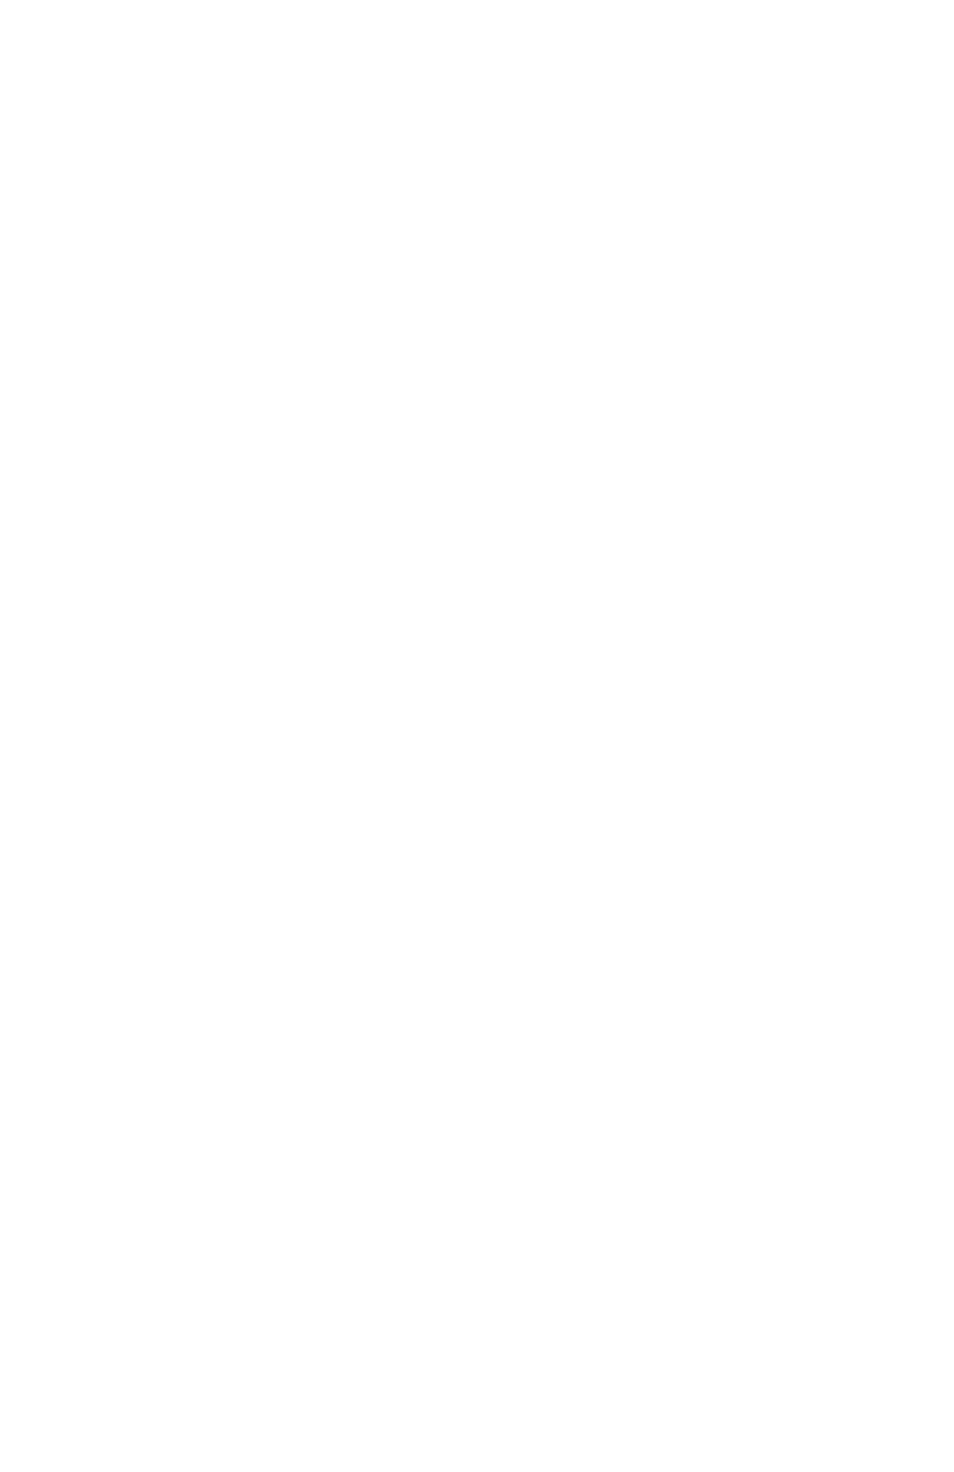

In [69]:
# Plotting the 10 words that contribute the most for each of the 8 emotions

fig, axs = plt.subplots(figsize=(15, 25), frameon=False) 
plt.box(False)
plt.axis('off')
plt.subplots_adjust(hspace = 1.6)
counter = 0

for i, emotion in enumerate(emotions): # for each emotioin

    # This is the dict that holds the top 10 words 
    words, top_words, top_words_indices = get_top_emotion_words(list_emotion_counts[i]['emo_frq'], 10)
    
    info = {'values' : [words[ind][1] for ind in top_words_indices], 
                      'labels' : [ind_to_word[word] for word in top_words]}
    sns.set(style="whitegrid")
    sns.set_context("notebook", font_scale=1.25)
    ax = fig.add_subplot(4, 2, counter+1) # plot 2 charts in each of the 4 rows
    sns.despine()
    ax = sns.barplot(x='labels', y='values', data=info, palette=("cividis"))
    plt.ylabel('Top words', fontsize=12)
    ax.set_title(label=str('Emotion: ') + emotion, fontweight='bold', size=13)
    plt.xticks(rotation=45, fontsize=14)
    counter += 1

axs.set_title(label='\nTop 10 words for each emotion\n', 
             fontweight='bold', size=20, pad=40)
plt.tight_layout()
#plt.savefig('images/Top10_words_per_emotion.png')

For some authors, isolated emotions might not be the best granullarity for analysis. Skillicorn (2019) and colleagues prefer to aggregate emotions into positive and negative emotions [5]. Let's try it.

In [ ]:
# Aggregating negative and positive emotions
df_emo['neg_emotions'] = df_emo['Sadness'] + df_emo['Fear'] + df_emo['Disgust'] + df_emo['Anger']
df_emo['pos_emotions'] = df_emo['Joy'] + df_emo['Anticipation'] + df_emo['Trust'] + df_emo['Surprise']

In [ ]:
df_emo['total_neg_emotions'] = df_emo['neg_emotions'].apply(lambda x: x > 0)
df_emo['total_pos_emotions'] = df_emo['pos_emotions'].apply(lambda x: x > 0)

I use here the pandas groupby feature to obtain a normalized account of the emotions as a proportion that takes into account the number of tweets in each of the two periods (before and during the online storm).

In [ ]:
props = df_emo.groupby('onlinestorm')['total_neg_emotions'].value_counts(normalize=True).unstack()
props

The results show that during the online storm period, negative emotions are present in 42 per cent of the tweets, whereas previously only 11% of the tweets included negative emotions.

We can spot it more clearly in the following chart ...

In [ ]:
# plot it
plot_fractions(props,'Percentage of tweets with negative emotions','Percentage_of_Tweets_with_negative_emotions')

Converselly, when it comes to positive emotions, we witness also an increase in the proportion of tweets with these emotions during online storm (84 per cent). But it is not such a sharp change when compared to the 61 per cent before the online storm.

In [ ]:
props = df_emo.groupby('onlinestorm')['total_pos_emotions'].value_counts(normalize=True).unstack()
props

In [ ]:
plot_fractions(props,'Percentage of tweets with positive emotions','Percentage_of_Tweets_with_positive_emotions')

### Word - emotion connections in the tweets

To help us have a feeling of how things work behind thew scenes, I wrote a function (print_colored_emotions) to display the words connected to negative (red) and positive (green) emotions.

It is important to acknowledge that I am not giving any kind of emotion score to the tweets (that would be another undertaking all together). I am just locating the word-emotion connections within the tweets, since a tweet may depict more than one emotion (or cluster of emotions) – and they usually do.

Here are some negative emotions ...

In [ ]:
df = df_emo[df_emo['Sadness'] > 3]
print_colored_emotions(df['text'], ['Disgust','Sadness','Anger','Fear'], 'white', 'on_red')

And here some positive ones ...

In [ ]:
df = df_emo[df_emo['Anticipation'] > 4]
print_colored_emotions(df['text'], ['Joy','Trust','Anticipation'], 'white', 'on_green')

### Proportion of emotions in relation to number of tweets, before and during the online storm 

In [ ]:
df1 = df_emo.groupby(df_emo['onlinestorm'])[emotions].apply(lambda x:( x.sum()/x.count())*100)

In [ ]:
df1.index = ['before_onlinestorm', 'during_onlinestorm']

In [ ]:
df1.head()

In [ ]:
df_ =df1.T

In [ ]:
df_.reset_index()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title(label='Comparing percentage of emotion-related words before and during online storm\n', fontweight='bold', size=18)
df_.reset_index().plot(
    x="index", y=["before_onlinestorm", "during_onlinestorm"], kind="bar", ax=ax
)



plt.xlabel("Emotions",fontsize = 16)
plt.ylabel("Percentage of emotion-related words",fontsize = 16)
plt.xticks(rotation=45,fontsize=14)
plt.tight_layout()
plt.savefig('images/Percentage_emotions_before_and_during_onlinestorm.png')

### Applying a Z-score normalization

In another effort to normalize the emotion scores, I am using the Z-score, instead of the mere counts of word-emotion connections, because these are heavily affected by the number of tweets in each period in consideration.

The z-score tells us how many standard deviations an individual value is from the mean, and is calculated with following formula:

<img src="images/zscore.png">

I use the pandas’ apply function to calculate the z-score of each individual value in all the 8 columns of emotions in the dataframe.

In [ ]:
df_zscore = df_emo.groupby(df_emo['onlinestorm'])[emotions].apply(lambda x:(x - x.mean()) / x.std())  

In [ ]:
df_emo = pd.concat([df_emo[['datetime','text','edited', 'onlinestorm']], df_zscore], axis=1)

In [ ]:
df_emo.head()

### The dynamics of emotions during the online storm

With our normalized values, we can now have a more precise view of the way emotions evolved, by the hour, during the 3 days of the online storm. 

Here we have a mixture of all the emotions during online storm ...

In [ ]:
plot_emotions_period(df_emo[df_emo['onlinestorm']], emotions,
                    'Emotions time series during online storm','Timeseries_Emotions_OnlineStorm')

Let's see how each of the emotions evolved during this period ...

In [ ]:
# Plotting emotions during online storm

fig, axs = plt.subplots(figsize=(15, 25), frameon=False) 
plt.box(False)
plt.axis('off')
plt.subplots_adjust(hspace = 1.6)
counter = 0

df = df_emo[df_emo['onlinestorm']]
df1 = df.groupby(df['datetime'].dt.to_period('h')).mean()
df1.reset_index(inplace=True)
df1['datetime'] = pd.PeriodIndex(df1['datetime']).to_timestamp()

for i, emotion in enumerate(emotions): # for each emotion
    
    emo = []  
    emo.append(emotion)
    plot_df = pd.DataFrame(df1, df1.index, emo)
    
    sns.set(style="whitegrid")
    sns.set_context("notebook", font_scale=1.25)
    ax = fig.add_subplot(4, 2, counter+1) # plot 2 charts in each of the 4 rows
    sns.despine()
    ax = sns.lineplot(data=plot_df, linewidth = 3,dashes = False)
    plt.ylabel('Time by the hour', fontsize=12)
    ax.set_title(label=str('Emotion: ') + emotion, fontweight='bold', size=13)
    counter += 1

axs.set_title(label='\nPlot for each emotion during online storm\n', 
             fontweight='bold', size=20, pad=40)
plt.tight_layout()
plt.savefig('images/Emotions_during_onlinestorm.png')

Another way of looking at it is by plotting contrasts of emotions, like joy and sadness ...

In [ ]:
plot_emotions_period(df_emo[df_emo['onlinestorm']], ['Joy', 'Sadness'],
                    'Joy and Sadness time series during online storm','Joy_Sadness_Emotions_OnlineStorm')

And now trust and fear ...

In [ ]:
plot_emotions_period(df_emo[df_emo['onlinestorm']], ['Trust', 'Fear'],
                    'Trust and Fear time series during online storm','Trust_Fear_Emotions_OnlineStorm')

## References

[1] Hersausen, D., et al (2019) [Detecting, Preventing, and Mitigating Online
Firestorms in Brand Communities](https://www.researchgate.net/publication/330385319_Detecting_Preventing_and_Mitigating_Online_Firestorms_in_Brand_Communities). *Journal of Marketing*, 83(51).

[2] C.J. Hutto, Eric Gilbert (2014) [VADER: A Parsimonious Rule-based Model
for Sentiment Analysis of Social Media Text, Association for the Advancement
of Artificial Intelligence](https://www.researchgate.net/publication/275828927_VADER_A_Parsimonious_Rule-based_Model_for_Sentiment_Analysis_of_Social_Media_Text). *Association for the Advancement
of Artificial Intelligence.*

[3] Plutchik, R. (2001) The Nature of Emotions. American Scientist, vol 89.

[4] Saif, M., Turney, P. (2013) [Crowdsourcing a Word-Emotion Association Lexicon](https://www.researchgate.net/publication/256199465_Crowdsourcing_a_Word-Emotion_Association_Lexicon), *Computational Intelligence*, 29(3).

[5] Skillicorn, D., et al (2019) Measuring Human Emotion in Short Documents
to Improve Social Robot and Agent Interactions, Canadian AI 2019: Advances
in Artificial Intelligence.